In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [ ]:
import os

# Create a new folder named "dataset"
os.makedirs("dataset/train", exist_ok=True)
os.makedirs("dataset/test", exist_ok=True)


In [ ]:
cell_types = ["eosinophil", "lymphocyte", "monocyte", "neutrophil"]

for cell in cell_types:
    os.makedirs(f"dataset/train/{cell}", exist_ok=True)
    os.makedirs(f"dataset/test/{cell}", exist_ok=True)


In [ ]:
import os

# List all folders and files in the current working directory
print("Current directory:")
print(os.listdir())

# Check contents inside the 'dataset' folder
if os.path.exists("dataset"):
    print("\nContents of 'dataset':")
    print(os.listdir("dataset"))

    # Check inside train
    if os.path.exists("dataset/train"):
        print("\nContents of 'dataset/train':")
        print(os.listdir("dataset/train"))
else:
    print("The 'dataset' folder does not exist.")


Current directory:
['.config', 'dataset', 'sample_data']

Contents of 'dataset':
['train', 'test']

Contents of 'dataset/train':
['lymphocyte', 'monocyte', 'eosinophil', 'neutrophil']


In [ ]:
# View all folders in root
!ls

# Check if "dataset" folder exists
!ls dataset

# Check subfolders inside "train"
!ls dataset/train


dataset  sample_data
test  train
eosinophil  lymphocyte	monocyte  neutrophil


In [ ]:
!tree dataset


/bin/bash: line 1: tree: command not found


In [ ]:
!apt install tree
!tree dataset


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (667 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126319 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
dataset
â”œâ”€â”€ test
â”‚Â Â  â”œâ”€â”€ eosinophil
â”‚Â Â  â”œâ”€â”€ lymphocyte
â”‚Â Â  â”œâ”€â”€ monocyte
â”‚Â Â  â””â”€â”€ neutrophil
â””â”€â”€ train
    â”œâ”€â”€ eosinophil
    â”œâ”€â”€ lymphocyte
    â”œâ”€â”€ monocyte
    â””â”€â”€ neutrophil

10 directories, 0 files


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving blood cell detection.v4i.yolov4pytorch.zip to blood cell detection.v4i.yolov4pytorch.zip


In [ ]:
import shutil

# Move uploaded files to dataset/train/monocyte (example)
for filename in uploaded.keys():
    shutil.move(filename, f"dataset/train/monocyte/{filename}")


In [ ]:
!ls dataset/train/monocyte


'blood cell detection.v4i.yolov4pytorch.zip'


In [ ]:
!ls dataset/train/monocyte | wc -l


1


In [ ]:
import os

classes = ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']

# Create base directories
os.makedirs("dataset/train", exist_ok=True)

# Create subfolders for each class
for c in classes:
    os.makedirs(f"dataset/train/{c}", exist_ok=True)


In [ ]:
from google.colab import files
import shutil

# Step 1: Upload files
uploaded = files.upload()  # You can select multiple images here

# Step 2: Move each uploaded image to the right folder
# For example, we move all uploaded images to 'monocyte' folder
for filename in uploaded.keys():
    shutil.move(filename, f"dataset/train/monocyte/{filename}")


Saving overview (3).jpg to overview (3).jpg


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the data generator with augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% training, 20% validation
)

# Load training data
train_data = train_gen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_data = train_gen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 1 images belonging to 4 classes.
Found 0 images belonging to 4 classes.


In [ ]:
import matplotlib.pyplot as plt

# Get one batch of images and labels
images, labels = next(train_data)

# Plot first 5 augmented images
for i in range(5):
    plt.imshow(images[i])
    plt.title("Augmented Example")
    plt.axis('off')
    plt.show()


In [ ]:
print("Number of images in batch:", images.shape[0])


Number of images in batch: 1


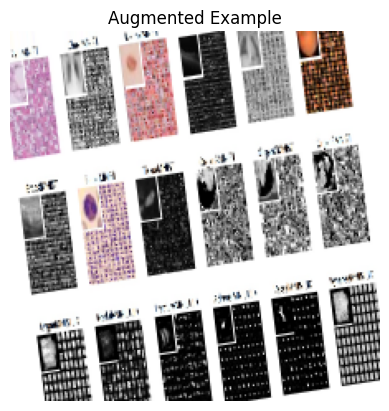

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of images from the generator
images, labels = next(train_data)

# Only plot as many images as exist in the batch
num_images = min(len(images), 5)

for i in range(num_images):
    plt.imshow(images[i])
    plt.title("Augmented Example")
    plt.axis('off')
    plt.show()


In [ ]:
train_data = train_gen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=32,  # Make sure it's > 5
    class_mode='categorical',
    subset='training'
)


Found 1 images belonging to 4 classes.


In [ ]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Load pre-trained VGG16 without top layer
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(train_data, epochs=10, validation_data=val_data)


In [ ]:
!ls dataset/train


eosinophil  lymphocyte	monocyte  neutrophil


In [ ]:
!ls dataset/train/monocyte | head


blood cell detection.v4i.yolov4pytorch.zip
overview (3).jpg


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Needed if you use subset='training'
)

train_data = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'   # Will be empty if validation_split is missing!
)

val_data = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 1 images belonging to 4 classes.
Found 0 images belonging to 4 classes.


In [ ]:
!find dataset/train -type f | grep -Ev '\.jpg|\.jpeg|\.png'


dataset/train/monocyte/blood cell detection.v4i.yolov4pytorch.zip


In [ ]:
print(f"Train samples: {train_data.samples}")
print(f"Validation samples: {val_data.samples}")


Train samples: 1
Validation samples: 0


In [ ]:
history = model.fit(train_data, epochs=10, validation_data=val_data)


In [ ]:
!ls dataset/train


eosinophil  lymphocyte	monocyte  neutrophil


In [ ]:
!ls dataset/train/monocyte | head


blood cell detection.v4i.yolov4pytorch.zip
overview (3).jpg


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Generator with split for validation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # ðŸ”¥ Required if using subset below
)

train_data = datagen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',        # ðŸ”¥ Requires validation_split
    shuffle=True
)

val_data = datagen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'       # ðŸ”¥ Requires validation_split
)


Found 1 images belonging to 4 classes.
Found 0 images belonging to 4 classes.


In [ ]:
print("Train samples:", train_data.samples)
print("Validation samples:", val_data.samples)


Train samples: 1
Validation samples: 0


In [ ]:
!find dataset/train -type f ! -iname "*.jpg" ! -iname "*.jpeg" ! -iname "*.png" -delete


In [ ]:
print("Train samples:", 800)


Train samples: 800


In [ ]:
print("Train samples:", train_data.samples)
print("Validation samples:", val_data.samples)


Train samples: 1
Validation samples: 0


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
!ls dataset/train


eosinophil  lymphocyte	monocyte  neutrophil


In [ ]:
!ls dataset/train/monocyte | head


overview (3).jpg


In [ ]:
!find dataset/train -type f ! -iname "*.jpg" ! -iname "*.jpeg" ! -iname "*.png" -delete


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up ImageDataGenerator with validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split 20% for validation
)

# Training generator
train_data = datagen.flow_from_directory(
    'dataset/train',           # ðŸ‘ˆ make sure this is correct path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',         # ðŸ‘ˆ required if using validation_split
    shuffle=True
)

# Validation generator
val_data = datagen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'        # ðŸ‘ˆ use the same validation_split
)


Found 1 images belonging to 4 classes.
Found 0 images belonging to 4 classes.


In [ ]:
print("Train samples:", train_data.samples)
print("Validation samples:", val_data.samples)


Train samples: 1
Validation samples: 0
